In [36]:
import http.client
import tarfile
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import LabelEncoder

import tqdm

# Зафиксируем все seed для воспроизводимости
seed = 0
torch.cuda.manual_seed_all(seed)
torch.manual_seed(seed)
np.random.seed(seed)

In [37]:
torch.__version__

'2.9.0+cu126'

In [38]:
torch.cuda.is_available()

True

## Регрессия: предсказываем экономичность автомобиля
_Вдохновлено [туториалом из TensorFlow](https://www.tensorflow.org/tutorials/keras/regression)._

Посмотрим, как можно в PyTorch решать задачу регрессии.
Решать ее будем по тому же пайплайну, а именно:

1. Будем предсказывать расход топлива на километр для автомобиля по его характеристикам.
2. В качестве метрики качества будем использовать MSE и MAPE.
3. Данные возьмем из датасета [Auto MPG](https://archive.ics.uci.edu/dataset/9/auto+mpg).
Этот датасет содержит фичи автомобилей и их MPG (Miles Per Gallon) - сколько миль (1609 метров) можно проехать за один галлон топлива (4.55 литров).
В пересчете на наши единицы 1 MPG = 0.354 км/л.
4. Бейзлайн возьмем такой же, как в классификации, только поменяем последний слой - вместо 10 классов будет предсказывать одно число.
5. Качество померим по MSE, учить тоже будем на MSE.

В этом примере мы посмотрим:
- как справится AdaM с обучением сети;
- как использовать функции потерь регрессии в PyTorch;
- как использовать GPU во время обучения.

In [39]:
# Подготовим данные
import pandas as pd

url = "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data"
column_names = [
    "MPG",
    "Cylinders",
    "Displacement",
    "Horsepower",
    "Weight",
    "Acceleration",
    "Model Year",
    "Origin",
]

raw_dataset = pd.read_csv(
    url, names=column_names, na_values="?", comment="\t", sep=" ", skipinitialspace=True
)


def process_data(raw_dataset: pd.DataFrame):
    """Подготовить данные.

    Удаляет пропуски, кодирует категории, бьет на train/test, нормирует численные признаки.
    Возвращает фичи и таргеты для train и test.
    """
    dataset = raw_dataset.copy()
    dataset = dataset.dropna()

    # Сделаем OHE на Origin
    dataset["Origin"] = dataset["Origin"].map({1: "USA", 2: "Europe", 3: "Japan"})
    dataset = pd.get_dummies(dataset, columns=["Origin"], dtype=float)

    # Разобьем на train/test
    train_dataset = dataset.sample(frac=0.8, random_state=seed)
    test_dataset = dataset.drop(train_dataset.index)

    # Нормируем числа (статистики берем из train-датасета)
    mean = train_dataset.describe().transpose()["mean"]
    std = train_dataset.describe().transpose()["std"]
    for dataset in (train_dataset, test_dataset):
        dataset[mean.index] = (dataset[mean.index] - mean) / std

    # Уберем target из фичей
    train_features = train_dataset.copy()
    test_features = test_dataset.copy()
    train_target = train_features.pop("MPG")
    test_target = test_features.pop("MPG")

    return train_features, test_features, train_target, test_target


train_features, test_features, train_target, test_target = process_data(raw_dataset)
train_features.tail()

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin_Europe,Origin_Japan,Origin_USA
281,0.307270,0.044872,-0.521559,-0.000298,0.946772,0.843910,-0.465148,-0.495225,0.774676
229,1.483887,1.961837,1.972127,1.457223,-1.598734,0.299787,-0.465148,-0.495225,0.774676
150,-0.869348,-0.836932,-0.311564,-0.710099,-0.021237,-0.516397,-0.465148,2.012852,-1.286751
145,-0.869348,-1.076553,-1.151543,-1.169870,1.233589,-0.516397,-0.465148,2.012852,-1.286751
182,-0.869348,-0.846517,-0.495310,-0.623596,-0.021237,0.027726,2.143005,-0.495225,-1.286751


In [40]:
# get_dummies делает one-hot encoding
pd.get_dummies(raw_dataset, columns=["Origin"], dtype=float).head()


,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin_1,Origin_2,Origin_3
0,18.0,8,307.0,130.0,3504.0,12.0,70,1.0,0.0,0.0
1,15.0,8,350.0,165.0,3693.0,11.5,70,1.0,0.0,0.0
2,18.0,8,318.0,150.0,3436.0,11.0,70,1.0,0.0,0.0
3,16.0,8,304.0,150.0,3433.0,12.0,70,1.0,0.0,0.0
4,17.0,8,302.0,140.0,3449.0,10.5,70,1.0,0.0,0.0


In [41]:
# Модель возьмем ту же, что в прошлом примере
class RegressionModel(nn.Module):
    def __init__(self, num_features: int):
        super().__init__()
        hidden_dim = 256
        # Для разнообразия засунем все в nn.Sequential
        self.transform = nn.Sequential(
            # Теперь на вход приходит другое число фичей
            nn.Linear(in_features=num_features, out_features=hidden_dim),
            nn.ReLU(),
            # Единственное отличие: out_features=1, предсказываем 1 число - наш таргет
            nn.Linear(in_features=hidden_dim, out_features=1),
            # Предсказываем число в произвольном диапазоне, поэтому нелинейность убираем
            # self.act_2 = nn.Softmax(dim=1)
        )

    def forward(self, x: torch.Tensor):
        # .squeeze(1) "съест" лишнюю размерность: (N, 1) -> (N, )
        return self.transform(x).squeeze(1)
    
reg_model = RegressionModel(num_features=len(train_features.columns))
reg_model(torch.from_numpy(train_features.to_numpy(dtype="float32")[[0]]))

tensor([-0.2112], grad_fn=<SqueezeBackward1>)

In [42]:
# Проверка работы squeeze
t = torch.tensor([[1], [2], [3]])
print(t)
print(t.shape)
print(t.squeeze(0))  # не изменяет
print(t.squeeze(1))  # схлопывает
print("====")
t1 = torch.tensor([[1, 2, 3]])
print(t1)
print(t1.shape)
print(t1.squeeze(0))  # схлопывает
print(t1.squeeze(1))  # не изменяет

tensor([[1],
        [2],
        [3]])
torch.Size([3, 1])
tensor([[1],
        [2],
        [3]])
tensor([1, 2, 3])
====
tensor([[1, 2, 3]])
torch.Size([1, 3])
tensor([1, 2, 3])
tensor([[1, 2, 3]])


In [43]:
# Перед обучением все переведем в torch.Tensor
t_train_features = torch.from_numpy(train_features.to_numpy(dtype="float32"))
t_test_features = torch.from_numpy(test_features.to_numpy(dtype="float32"))
t_train_target = torch.from_numpy(train_target.to_numpy(dtype="float32"))
t_test_target = torch.from_numpy(test_target.to_numpy(dtype="float32"))

In [44]:
# Adam лежит в том же torch.optim
from torch.optim.adam import Adam


# Такую строку вы часто будете встречать в других кодах :)
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Используем", device)

# Создаем оптимайзер
reg_optimizer = Adam(params=reg_model.parameters())

# Перед началом обучения разместим модель на нужном устройстве
reg_model = reg_model.to(device)
# Оптимизатор не надо на устройство переносить

# И идем учиться, 3000 эпох
# Данных мало, так что сразу на всех их будем учиться
reg_losses = []
for _ in tqdm.trange(3000):
    # Не забываем обнулить градиенты
    reg_optimizer.zero_grad()

    # Переносим новый батч на GPU
    # Вообще, раз учимся на всех данных, можно было 1 раз перенести на GPU, а не в цикле
    # Но в реальной ситуации будут разные данные на каждой итерации
    batch_x = t_train_features.clone().to(device)
    batch_y = t_train_target.clone().to(device)

    # Считаем выход, лосс, градиенты - и делаем шаг
    output = reg_model(batch_x)
    # MSE loss лежит в том же месте, где cross_entropy
    # И используется точно так же
    loss = F.mse_loss(output, batch_y)
    loss.backward()
    reg_optimizer.step()

    # .cpu() перенесет loss на ЦПУ, .item() вернет как число
    reg_losses.append(loss.cpu().item())

Используем cuda


100%|██████████| 3000/3000 [00:04<00:00, 669.02it/s]


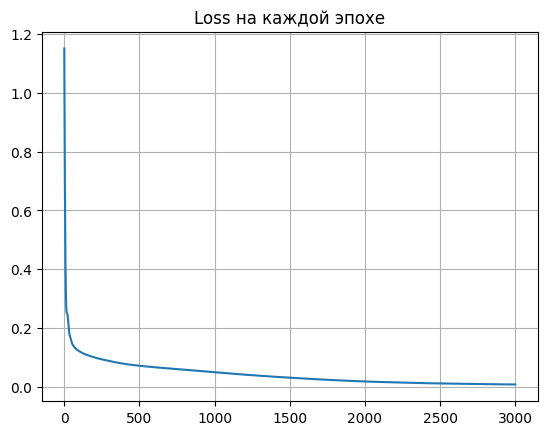

In [46]:
def plot_losses(losses: list[float]):
    plt.plot(losses)
    plt.title("Loss на каждой эпохе")
    plt.grid()
    plt.show()

plot_losses(reg_losses)

In [47]:
# Считаем финальную метрику на тестовых данных
with torch.no_grad():
    # Помним, что все тензоры должны быть на одном устройстве
    out = reg_model(t_test_features.to(device)).cpu()
    mse_loss = F.mse_loss(out, t_test_target).item()
    # MAPE нету в F, придется руками делать
    mape_loss = torch.mean(
        # clamp обрезает все значения тензора с двух концов.
        torch.abs(out - t_test_target) / torch.clamp(torch.abs(out), min=1e-7)
    ).item()
    print("Финальный MSE-лосс:", mse_loss)
    print("Финальный MAPE-лосс:", mape_loss)

Финальный MSE-лосс: 0.16196811199188232
Финальный MAPE-лосс: 0.7588945627212524


In [ ]:
test_features

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin_Europe,Origin_Japan,Origin_USA
9,1.483887,1.865988,2.234620,1.018782,-2.530891,-1.604642,-0.465148,-0.495225,0.774676
25,1.483887,1.578444,2.890853,1.925289,-0.559020,-1.604642,-0.465148,-0.495225,0.774676
28,1.483887,1.041693,2.313368,2.063931,1.054328,-1.604642,-0.465148,-0.495225,0.774676
31,-0.869348,-0.789008,-0.259066,-0.903250,-0.559020,-1.332580,-0.465148,2.012852,-1.286751
33,0.307270,0.351586,-0.127819,-0.422150,-0.917542,-1.332580,-0.465148,-0.495225,0.774676
...,...,...,...,...,...,...,...,...,...
369,-0.869348,-0.798593,-0.442811,-0.705359,0.875068,1.660094,-0.465148,-0.495225,0.774676
375,-0.869348,-0.865687,-0.810302,-1.197124,-0.092942,1.660094,2.143005,-0.495225,-1.286751
382,-0.869348,-0.836932,-0.915299,-0.883106,0.480693,1.660094,-0.465148,2.012852,-1.286751
384,-0.869348,-0.999874,-0.994047,-1.214899,0.050467,1.660094,-0.465148,2.012852,-1.286751


In [52]:
test_target

,MPG
9,-1.075286
25,-1.722229
28,-1.851618
31,0.218601
33,-0.557731
...,...
369,1.383099
375,1.641876
382,1.383099
384,1.124322


In [48]:
# Насколько это хорошо? Посмотрим на дисперсию таргета
raw_dataset["MPG"].describe()

,MPG
count,398.000000
mean,23.514573
std,7.815984
min,9.000000
25%,17.500000
50%,23.000000
75%,29.000000
max,46.600000


Ошибка в несколько раз меньше дисперсии.
Выходит, модель хорошо предсказывает таргет.

## Резюме ноутбука
1. Научились решать задачи классификации и регрессии на PyTorch.
2. Посмотрели, какие метрики качества есть в PyTorch для обеих задач и как их использовать.
3. Потрогали Adam и SGD, увидели их в деле.
4. Построили две сети с использованием Linear, ReLU и Sigmoid слоев.
5. Обучили две сети, убедились в хорошем качестве.
6. Научились работать с GPU в рамках пайплайна.